In [69]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [70]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fredapi import Fred
import requests
from scipy.stats import skew
from scipy.stats import kurtosis

# Data Preprocessing

## Data Sources
In our research, we'll be using multiple sources of oil prices data for each of three regions that are discussed in the paper: United States, Russia and Middle East.
Data for US crude oil benchmark West Texas Intermediate (WTI) is coming from two main sources provided by the U.S. government. The first one is the Energy Information Administration (EIA), which gives us information about the crude oil prices, including prices for derived oil products such as gasoline, jet fuel, diesel, heating oil and propane. The second source is the Federal Reserve Economic Data, St. Louis (FRED), maintained by the Federal Reserve Bank of St. Louis. FRED provides economic time-series data.
The time-series is obtained through open data tools and Application Programming Interface (API).

Middle East region is represented by Dubai crude which is commonly used as benchmark for the pricing of Middle Eastern oil, consisting of Dubai, Oman or Abu Dhabi oil.

Russian oil is represented by Urals blend.

## Methodology

In order to analyze relations between oil and oil products we identified prices of crude oil and related oil products for three separate locations. Data was collected using RESTful API requests to query the government agencies sources such as EIA and IMF. In Python it's done with help of **requests** library allowing us to make the API calls with specified search parameters(time period, frequency, etc). 

In this study, we'll be focusing on the last five years, starting from October 2018 and going up to October 2023. We chose this time frame to assess how COVID-19, the Russia-Ukraine war, and Israel Hammas-Israel war affected petroleum prices. A five-year period provides a sufficiently large dataset for statistical analysis. This will allow us to perform the Exploratory Data Analysis(EDA) to draw meaningful conclusions about the relationships and correlations within the data. EDA is conducted using Python and popular data analysis libraries such as pandas, matplotlib, and seaborn. 

First, we imported oil prices into a Pandas DataFrame for easier work with tabular data. Next step was to organize data by combining all prices in one dataframe, naming columns and setting proper datatime index to manipulate the time-series. Subsequently, the data was inspected for missing values to ensure data quality. As a part of EDA to visualize the cleaned data libraries  **matplotlib** and **seaborn** were used.

For further statistical analysis we calculated the daily returns on the prices and plotted the distribution of the retruns.



In [71]:
# EIA API connection details
api_key = "WyIzc4qhpYE6rxEDvB216tCCuvSkHBwGLJ6ddpam"
eia_url = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'

# List of oil products and codes
products = [
  {'name': 'WTI Crude', 'code':'RWTC'},
  {'name': 'Gasoline', 'code':'EER_EPMRU_PF4_Y35NY_DPG'},
  {'name': 'Jet Fuel', 'code':'EER_EPJK_PF4_RGC_DPG'},
  {'name': 'Diesel', 'code':'EER_EPD2DXL0_PF4_Y35NY_DPG'},
  {'name': 'Heating Oil', 'code':'EER_EPD2F_PF4_Y35NY_DPG'},
  {'name': 'Propane', 'code':'EER_EPLLPA_PF4_Y44MB_DPG'}
  ]

start_date = '2018-10-01'
end_date = '2023-10-01'
date_range = pd.date_range(start_date, end_date, freq='D').strftime('%Y-%m-%d')

oil_products_df = pd.DataFrame(date_range, columns=['period'])

for product in products: 
  # Query parameters 
  params = '?frequency=daily&data[0]=value&facets[series][]=%s&start=%s&end=%s&sort[0][column]=period&sort[0][direction]=desc&api_key=%s' % (product['code'], start_date, end_date, api_key)

  # Fetch the data using GET request
  data = requests.get(eia_url + params).json()
  df = pd.DataFrame(data['response']['data'])
  
  # Naming column with oil product name
  df.rename(columns={"value": product['name']}, inplace=True) 

  # Merging price series
  oil_products_df = pd.merge(oil_products_df, df[['period', product['name']]], on='period') 
  
# Setting proper index
oil_products_df['period'] = pd.to_datetime(df['period'])
oil_products_df.set_index('period', inplace=True)


oil_products_df.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
period,,,,,,
2023-09-29,75.37,2.195,2.327,2.412,2.389,1.100
2023-09-28,75.16,2.204,2.317,2.397,2.372,1.075
2023-09-27,76.40,2.219,2.345,2.432,2.410,1.063
2023-09-26,74.44,2.189,2.312,2.399,2.379,1.035
2023-09-25,74.26,2.170,2.301,2.388,2.368,1.040


In [72]:
# Check for missing values
oil_products_df.isna().value_counts()

WTI Crude  Gasoline  Jet Fuel  Diesel  Heating Oil  Propane
False      False     False     False   False        False      1256
dtype: int64

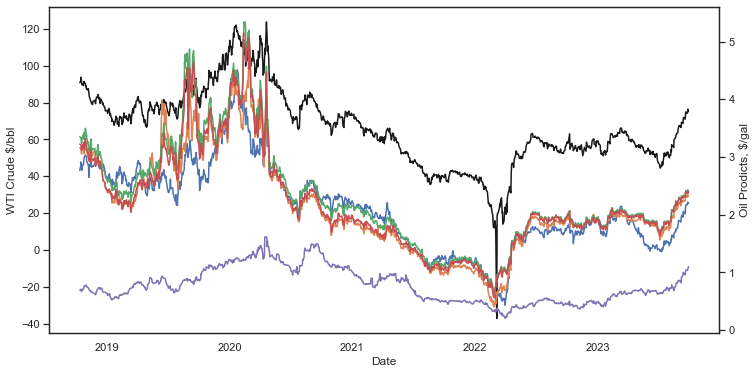

In [73]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the WTI Crude Oil prices on the left axis
ax1.set_xlabel('Date')
ax1.set_ylabel('WTI Crude $/bbl')
ax1.plot(oil_products_df.index, oil_products_df['WTI Crude'], color='k')

# Plot the oil products prices on the right axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Prodicts, $/gal')
for column in ['Gasoline', 'Jet Fuel', 'Diesel', 'Heating Oil', 'Propane']:
  ax2.plot(oil_products_df.index, oil_products_df[column], label=column)

# Show the plot
plt.show()

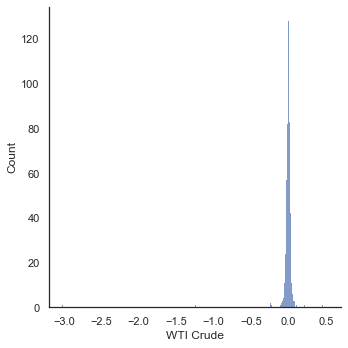

In [74]:
returns_df = oil_products_df.pct_change()
sns.displot(returns_df.iloc[1:], x="WTI Crude")

In [75]:
# Calculate the correlation matrix
correlation_matrix = oil_products_df.corr()
correlation_matrix.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
WTI Crude,1.000000,0.971792,0.928976,0.923657,0.917030,0.783768
Gasoline,0.971792,1.000000,0.928772,0.930415,0.920793,0.711566
Jet Fuel,0.928976,0.928772,1.000000,0.980033,0.980791,0.626935
Diesel,0.923657,0.930415,0.980033,1.000000,0.997419,0.639255
Heating Oil,0.917030,0.920793,0.980791,0.997419,1.000000,0.622196


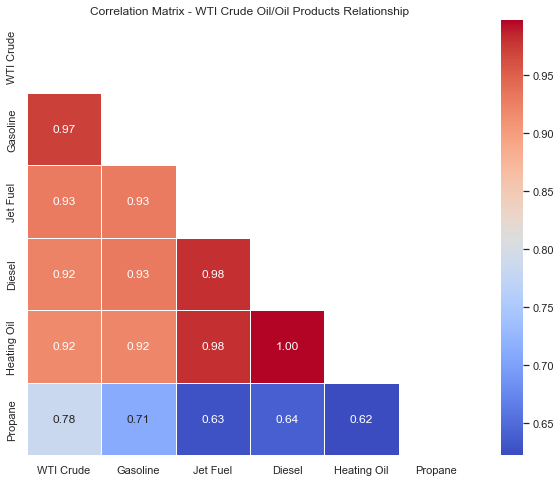

In [76]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Matrix - WTI Crude Oil/Oil Products Relationship')
plt.show()

In [77]:
# Calculate the skewness 
print(skew(oil_products_df, axis=0, bias=True))

[0.09907592 0.36766917 0.59020436 0.86114061 0.90334751 0.53160474]


In [78]:
print(kurtosis(oil_products_df, axis=0, bias=True))

[ 0.37543982  0.03417346 -0.06485345  0.42366133  0.55712222 -0.61378629]


In [79]:
urals_df = pd.read_csv('data/urals_prices.csv', sep=';')
urals_df.head()

,09.11.2023,68.46
0,08.11.2023,68.41
1,07.11.2023,70.46
2,06.11.2023,74.04
3,03.11.2023,73.80
4,02.11.2023,74.46


<AxesSubplot:>

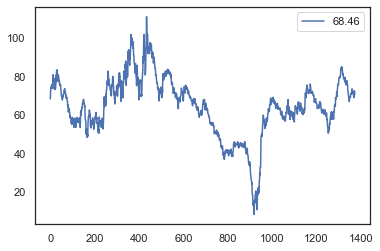

In [80]:
urals_df.plot()

## Dubai Crude prices in $ per barrel from International Monetary Fund API

In [81]:
# Obtaining Dubai Crude time-series from IMF using API query
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCPS/M.W00.POILDUB.USD'
data = (requests.get(url).json()
        ['CompactData']['DataSet']['Series'])

# Preparing the data
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
             for obs in data['Obs']]

# Create dataframe from array of dates and values
dubai_crude_df = pd.DataFrame(data_list, columns=['Date', 'Dubai Crude'])

# Setting datetime index
dubai_crude_df['Date'] = pd.to_datetime(dubai_crude_df['Date'])
dubai_crude_df.set_index(['Date'], inplace=True)

# Leaving 2 decimal palces
dubai_crude_df['Dubai Crude'] = dubai_crude_df['Dubai Crude'].astype(float).round(2)

dubai_crude_df.head()

,Dubai Crude
Date,
1990-01-01,17.50
1990-02-01,16.68
1990-03-01,15.76
1990-04-01,14.25
1990-05-01,14.65


In [82]:
# Checking for missing values
dubai_crude_df.isna().value_counts()

Dubai Crude
False          406
dtype: int64

<AxesSubplot:xlabel='Date'>

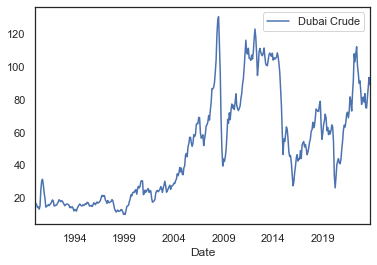

In [83]:
dubai_crude_df.plot()